In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

## 2019~2021년 화재건수 데이터 전처리
- fire_2019.csv, fire_2020.csv, fire_2021.csv 활용
- '시도'에서 충청남도만 추출
- '화재발생년월일'을 월만 표시하도록 변경 -> 'O월'
- 이후 차트에 표시하기 위해 길이가 긴 '시군구'는 줄바꿈 추가 -> 천안시서북구 = 천안시\n서북구, 천안시동남구 = 천안시\n동남구
- 인명/재산 피해가 나타나지 않은 화재 사고는 제거


In [ ]:
# 전국 2019~2021년 화재 사고 데이터셋
fire_2019 = pd.read_csv("fire_2019.csv", encoding='CP949')
fire_2020 = pd.read_csv("fire_2020.csv", encoding='CP949')
fire_2021 = pd.read_csv("fire_2021.csv", encoding='CP949')

# 충청남도 지역만 데이터 사용
fire_chungnam_2019 = fire_2019[fire_2019['시도'] == '충청남도']
fire_chungnam_2020 = fire_2020[fire_2020['시도'] == '충청남도']
fire_chungnam_2021 = fire_2021[fire_2021['시도'] == '충청남도']

# 월별로 나타냄
fire_chungnam_2019['화재발생년월일'] = fire_chungnam_2019['화재발생년월일'].apply(lambda x: x[5:7]+'월')
fire_chungnam_2020['화재발생년월일'] = fire_chungnam_2020['화재발생년월일'].apply(lambda x: x[5:7]+'월')
fire_chungnam_2021['화재발생년월일'] = fire_chungnam_2021['화재발생년월일'].apply(lambda x: x[5:7]+'월')

# 길이가 긴 지역에 줄바꿈 추가
fire_chungnam_2019['시군구'] = fire_chungnam_2019['시군구'].apply(lambda x: x[:3] + '\n' + x[3:] if len(x) > 3 else x)
fire_chungnam_2020['시군구'] = fire_chungnam_2020['시군구'].apply(lambda x: x[:3] + '\n' + x[3:] if len(x) > 3 else x)
fire_chungnam_2021['시군구'] = fire_chungnam_2021['시군구'].apply(lambda x: x[:3] + '\n' + x[3:] if len(x) > 3 else x)

# 인명피해, 재산피해가 나타나지 않은 화재 사고는 제거
fire_chungnam_2019.dropna(inplace = True)
fire_chungnam_2020.dropna(inplace = True)
fire_chungnam_2021.dropna(inplace = True)

## 소방서 위치 표시 (총 16개)
- fire_station.csv 활용
- 소방학교를 제외한 충청남도 소방서와 119안전센터를 지도 위에 표시
- json 파일을 활용하여 충청남도 소방서 관할 구역 표시

In [ ]:
fire_station = pd.read_csv("fire_station.csv", encoding="CP949")
fire_save_center = pd.read_csv('chungnam_save_center.csv', encoding="CP949")

# 소방학교는 제외
fire_station.drop(0, axis=0, inplace=True)

latitude = fire_station['위도']
hardness = fire_station['경도']
name = fire_station['소방서관서명']

myMap = folium.Map(location=[latitude.mean(), hardness.mean()], zoom_start=9)

def loc_chungnam(location, color):
    with open(location, mode='rt', encoding='utf-8') as f:
        geo = json.loads(f.read())
        f.close()

    folium.Choropleth(
        geo_data=geo,
        fill_opacity=1,
        line_opacity=0.1,
        fill_color=color,
        weight=0.3,
        name='chungnam_municipalities'
    ).add_to(myMap)

loc = ['./location/asan.json', './location/boryeong.json', './location/buyeo.json', './location/chungyang.json', './location/dangjin.json', './location/dongnamgu.json',
       './location/gongjusi.json', './location/geumsan.json', './location/hongsung.json', './location/gyeryong.json', './location/nonsan.json', './location/seobukgu.json',
       './location/seosan.json', './location/taean.json', './location/yaesan.json', './location/seocheon.json']
color = ['#D2B48C', '#F5DEB3', '#FFC0CB', '#1ABC9C', '#F2C80F', '#9B59B6', '#808080', '#27AE60',
        '#FAD02E', '#3498DB', '#BDB76B', '#2980B9', '#8E44AD', '#2ECC71', '#E67E22', '#2C3E50']

for i, j in zip(loc, color):
    loc_chungnam(i, j)

# 안전센터 지도에 표시
latitude = fire_save_center['위도']
hardness = fire_save_center['경도']
name = fire_save_center['119안전센터명']

for (l, h, n) in zip(latitude, hardness, name):
   folium.Circle([l, h], tooltip = n, color='aqua', fill_color='aqua', fill_opacity=1).add_to(myMap)


# 소방서 지도에 표시
latitude = fire_station['위도']
hardness = fire_station['경도']
name = fire_station['소방서관서명']

for (l, h, n) in zip(latitude, hardness, name):
   folium.Circle([l, h], tooltip = n, color='red', fill_color='red', fill_opacity=1, radius=100).add_to(myMap)

myMap

## 사용할 차트
---
1. 지역별 화재 발생 수(피해액 350,000원 이상) - 2019 ~ 2021년(barh)
2. 월별 화재피해자산(동+부동) - 비율, 금액(plot, bar)
3. 화재 발생 장소(소 or 중 or 대) - 2019 ~ 2021년(heatmap)

### 지역별 화재 발생 수(피해액 350,000원 이상)

In [ ]:
fire_gen_region_2019 = fire_chungnam_2019[fire_chungnam_2019['재산피해소계'] > 350]
fire_gen_region_2020 = fire_chungnam_2020[fire_chungnam_2020['재산피해소계'] > 350]
fire_gen_region_2021 = fire_chungnam_2021[fire_chungnam_2021['재산피해소계'] > 350]

fire_gen_region_2019 = fire_gen_region_2019['시군구'].value_counts(ascending=True)
fire_gen_region_2020 = fire_gen_region_2020['시군구'].value_counts(ascending=True)
fire_gen_region_2021 = fire_gen_region_2021['시군구'].value_counts(ascending=True)

fire_gen_region_2019 = fire_gen_region_2019.rename(index = {'천안시\n동남구': '천안시동남구', '천안시\n서북구': '천안시서북구'})
fire_gen_region_2020 = fire_gen_region_2020.rename(index = {'천안시\n동남구': '천안시동남구', '천안시\n서북구': '천안시서북구'})
fire_gen_region_2021 = fire_gen_region_2021.rename(index = {'천안시\n동남구': '천안시동남구', '천안시\n서북구': '천안시서북구'})

def show_text(ind, val, sub):
    for i, v in enumerate(ind):
        ax[sub].text(val[i], v, val[i],
                fontsize = 9, 
                color='deepskyblue',
                horizontalalignment='left',
                verticalalignment='center')

index = np.arange(16)
bar_width = 0.25

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 4))
plt.style.use('seaborn-v0_8-pastel')
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)
plt.rc('font', family='NanumBarunGothic')

ax[0].barh(fire_gen_region_2019.index, fire_gen_region_2019)
ax[0].set_title('2019년 화재발생 수')
ax[0].set_xlabel('횟수(단위:번)')
ax[0].set_xticks(range(0, 181, 30))
ax[1].barh(fire_gen_region_2020.index, fire_gen_region_2020)
ax[1].set_title('2020년 화재발생 수')
ax[1].set_xlabel('횟수(단위:번)')
ax[1].set_xticks(range(0, 181, 30))
ax[2].barh(fire_gen_region_2021.index, fire_gen_region_2021)
ax[2].set_title('2021년 화재발생 수')
ax[2].set_xlabel('횟수(단위:번)')
ax[2].set_xticks(range(0, 181, 30))
show_text(fire_gen_region_2019.index, fire_gen_region_2019, 0)
show_text(fire_gen_region_2020.index, fire_gen_region_2020, 1)
show_text(fire_gen_region_2021.index, fire_gen_region_2021, 2)

plt.show()

### 월별 화재피해자산(동+부동) - 비율, 금액

#### 월별 화재피해자산(동+부동) - 비율

화재발생년월일
03월    13.269477
01월    12.979343
02월     9.617925
Name: 재산피해소계, dtype: float64 화재발생년월일
03월    26.638749
08월    12.062234
10월     9.838335
Name: 재산피해소계, dtype: float64 화재발생년월일
03월    43.079909
10월    11.058038
08월     6.700987
Name: 재산피해소계, dtype: float64


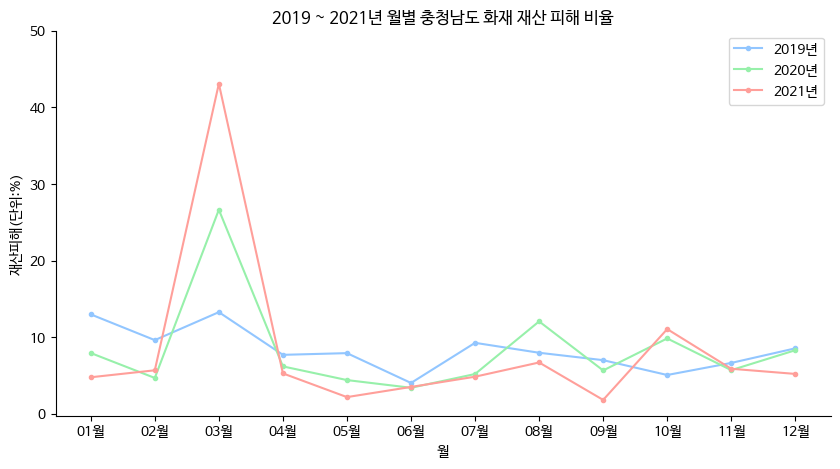

In [ ]:
fire_month_property_rate_2019 = fire_chungnam_2019.groupby('화재발생년월일')['재산피해소계'].sum()
fire_month_property_rate_2020 = fire_chungnam_2020.groupby('화재발생년월일')['재산피해소계'].sum()
fire_month_property_rate_2021 = fire_chungnam_2021.groupby('화재발생년월일')['재산피해소계'].sum()

fire_month_property_rate_2019 = fire_month_property_rate_2019.div(fire_month_property_rate_2019.sum(), axis=0) * 100
fire_month_property_rate_2020 = fire_month_property_rate_2020.div(fire_month_property_rate_2020.sum(), axis=0) * 100
fire_month_property_rate_2021 = fire_month_property_rate_2021.div(fire_month_property_rate_2021.sum(), axis=0) * 100
print(fire_month_property_rate_2019.sort_values(ascending=False)[:3], fire_month_property_rate_2020.sort_values(ascending=False)[:3], fire_month_property_rate_2021.sort_values(ascending=False)[:3])
plt.figure(figsize=(10, 5))
plt.style.use('seaborn-v0_8-pastel')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.rc('font', family='NanumBarunGothic')

x = fire_chungnam_2019['화재발생년월일']
plt.plot(fire_month_property_rate_2019, marker='o', markersize=3, label = '2019년')
plt.plot(fire_month_property_rate_2020, marker='o', markersize=3, label = '2020년')
plt.plot(fire_month_property_rate_2021, marker='o', markersize=3, label = '2021년')
plt.xlabel('월')
plt.ylabel('재산피해(단위:%)', size=10)
plt.title('2019 ~ 2021년 월별 충청남도 화재 재산 피해 비율')
plt.yticks(np.arange(0, 51, 10))
plt.legend()

plt.show()

#### 월별 화재피해자산(동+부동) - 금액

In [ ]:
rate = 100000
fire_month_property_2019 = fire_chungnam_2019.groupby('화재발생년월일')['재산피해소계'].sum() / rate
fire_month_property_2020 = fire_chungnam_2020.groupby('화재발생년월일')['재산피해소계'].sum() / rate
fire_month_property_2021 = fire_chungnam_2021.groupby('화재발생년월일')['재산피해소계'].sum() / rate

index = np.arange(12)
bar_width = 0.25

plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(10, 5))
plt.style.use('seaborn-v0_8-pastel')
plt.gca().spines[['top', 'right']].set_visible(False)

x = fire_chungnam_2019['화재발생년월일']
plt.bar(index - bar_width, fire_month_property_2019, bar_width, alpha=0.7, label='2019년')
plt.bar(index, fire_month_property_2020, bar_width, alpha=0.7, label='2020년')
plt.bar(index + bar_width, fire_month_property_2021, bar_width, alpha=0.7, label='2021년')
plt.plot(fire_month_property_2019.index, fire_month_property_2019, 'o--', markersize=3, alpha=0, color='grey')
plt.yticks(np.arange(0, 181, 20))
plt.xlabel('월')
plt.ylabel('재산피해(단위:억)', size=10)
plt.title('2019 ~ 2021년 월별 충청남도 화재 재산 피해 금액')
plt.legend()

### 화재 발생 장소(장소대분류) - 2019 ~ 2021년

In [ ]:
fire_gen_location_2019 = fire_chungnam_2019[fire_chungnam_2019['재산피해소계'] > 350]
fire_gen_location_2020 = fire_chungnam_2020[fire_chungnam_2020['재산피해소계'] > 350]
fire_gen_location_2021 = fire_chungnam_2021[fire_chungnam_2021['재산피해소계'] > 350]

def rm_new_line(data):
    data.loc[data['시군구'] == '천안시\n동남구', '시군구'] = '천안시동남구'
    data.loc[data['시군구'] == '천안시\n서북구', '시군구'] = '천안시서북구'

rm_new_line(fire_gen_location_2019)
rm_new_line(fire_gen_location_2020)
rm_new_line(fire_gen_location_2021)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(21, 7))
ax[0].set_title('2019년 충청남도 화재 발생 장소')
ax[1].set_title('2020년 충청남도 화재 발생 장소')
ax[2].set_title('2021년 충청남도 화재 발생 장소')
plt.style.use('seaborn-v0_8-pastel')
plt.rc('font', family='NanumBarunGothic')

def show_heatmap(data, axis):
    index = data['시군구']
    data = data.groupby(['시군구', '장소대분류']).size().reset_index(name='count')
    data_pivoted = data.pivot(index='시군구', columns='장소대분류', values='count')
    sns.heatmap(data_pivoted, annot=True, cmap='YlGnBu', ax=ax[axis], vmin=0, vmax=60)

show_heatmap(fire_gen_location_2019, 0)
show_heatmap(fire_gen_location_2020, 1)
show_heatmap(fire_gen_location_2021, 2)
ax[0].set_xlabel('장소')
ax[1].set_xlabel('장소')
ax[2].set_xlabel('장소')